In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv


In [2]:
import warnings
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In [3]:
# Write a wrangle function

def wrangle(filepath):
    # Read csv files into DataFrame
    df=pd.read_csv(filepath)
    
    # Subset to properties in Distrito Federal
    mask_ba=df["place_with_parent_names"].str.contains("Distrito Federal")
    
    # Subset to apartment
    mask_apt=df["property_type"]=="apartment"
    
    # Subset to properties where price usd <4000_000
    mask_price=df["price_aprox_usd"] < 4000_000
    # Subset
    df=df[mask_ba & mask_apt & mask_price]
    
    # Remove outliers by "surface_covered_in_m2"
    low, high=df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area=df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]
    
    # Drop columns 'Unnamed: 0'
    df.drop(columns=["Unnamed: 0"], inplace=True)
    
    # Extract neighborhood
    df["neighborhood"]=df["place_with_parent_names"].str.split("|",  expand=True)[1]
    df.drop(columns=["place_with_parent_names"], inplace=True)


    return df

In [4]:
# Use glob to create a list that contains the filenames for all the Mexico city real estate CSV files in the data directory

files = glob("/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-*.csv")
files

['/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv']

In [5]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [6]:
frames[0].head()

,operation,property_type,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,neighborhood
1,sell,apartment,"19.36269,-99.150565",1570000.0,MXN,1556166.19,82737.39,NaN,75.0,NaN,20933.333330,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/raei_ven...,Benito Juárez
2,sell,apartment,"19.39912,-99.141464",2700000.0,MXN,2675574.95,142253.50,NaN,92.0,NaN,29347.826090,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/odmz_ven...,Benito Juárez
3,sell,apartment,"19.291345,-99.124312",1370000.0,MXN,1357928.55,72197.60,NaN,62.0,NaN,22096.774190,NaN,NaN,NaN,http://tlalpan.properati.com.mx/r1ho_venta_dep...,Tlalpan
4,sell,apartment,"19.354987,-99.061709",840400.0,MXN,832797.49,44277.72,NaN,85.0,NaN,9887.058824,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/px1c_venta_...,Iztapalapa
6,sell,apartment,"19.39365,-99.14769",3671744.0,MXN,3639391.14,193497.15,NaN,56.0,NaN,65566.857140,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qwmb_ven...,Benito Juárez


In [7]:
df = pd.concat(frames, ignore_index=True)
df.shape

(10517, 16)

## Explore

I have modify the wrangle function to create a new feature "neighborhood", it can be found in the "place_with_parent_names" column.

## Split

In [8]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

# Build Model

## Baseline

In [9]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]* len(y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 139840.24549681466
Baseline MAE: 97097.63744007467


## Iterate

In [10]:
# instantiate
ohe = OneHotEncoder(use_cat_names=True)
# fit
ohe.fit(X_train)
# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(10517, 15)


,neighborhood_Benito Juárez,neighborhood_Tlalpan,neighborhood_Iztapalapa,neighborhood_Gustavo A. Madero,neighborhood_Venustiano Carranza,neighborhood_Cuauhtémoc,neighborhood_Álvaro Obregón,neighborhood_Iztacalco,neighborhood_Coyoacán,neighborhood_Miguel Hidalgo,neighborhood_Cuajimalpa de Morelos,neighborhood_Azcapotzalco,neighborhood_Tláhuac,neighborhood_La Magdalena Contreras,neighborhood_Xochimilco
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

## Evaluate

In [12]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 84504.8


## Communicate Results

In [13]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 15
[ 35219.61613514  18923.25489278 -68878.55472088 -51813.59447974
 -56279.52699684]


In [14]:
# Extract the feature names of encoded data from the OneHotEncoder
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 15
['neighborhood_Benito Juárez', 'neighborhood_Tlalpan', 'neighborhood_Iztapalapa', 'neighborhood_Gustavo A. Madero', 'neighborhood_Venustiano Carranza']


In [15]:
#  Create a pandas Series
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Benito Juárez          35219.616135
neighborhood_Tlalpan                18923.254893
neighborhood_Iztapalapa            -68878.554721
neighborhood_Gustavo A. Madero     -51813.594480
neighborhood_Venustiano Carranza   -56279.526997
dtype: float64

In [16]:
# Print the equation
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 114061.33
+ (35219.62 * neighborhood_Benito Juárez)
+ (18923.25 * neighborhood_Tlalpan)
+ (-68878.55 * neighborhood_Iztapalapa)
+ (-51813.59 * neighborhood_Gustavo A. Madero)
+ (-56279.53 * neighborhood_Venustiano Carranza)
+ (17523.77 * neighborhood_Cuauhtémoc)
+ (21276.04 * neighborhood_Álvaro Obregón)
+ (-59498.79 * neighborhood_Iztacalco)
+ (-19630.95 * neighborhood_Coyoacán)
+ (178935.18 * neighborhood_Miguel Hidalgo)
+ (127648.28 * neighborhood_Cuajimalpa de Morelos)
+ (-50067.73 * neighborhood_Azcapotzalco)
+ (-67215.25 * neighborhood_Tláhuac)
+ (28334.06 * neighborhood_La Magdalena Contreras)
+ (-54475.83 * neighborhood_Xochimilco)


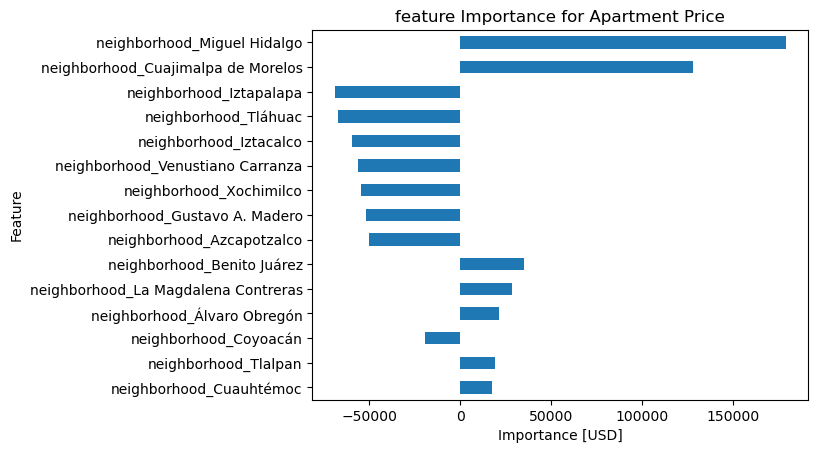

In [17]:
#  Create a horizontal bar chart that shows the top 15 coefficients for the model, based on their absolute value.

feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("feature Importance for Apartment Price");